# SimpleITK Exercise

This notebook includes code to get started with MIALab, where you will learn how it interacts with SimpleITK (a python library that helps read/write, and process medical image data).

Click on the "Open in Colab" button below to get started! If you have already made changes to this file, please instead download it and then open it in Google Colab manually.

<a target="_blank" href="https://colab.research.google.com/github/ubern-mialab/01-simpleITK/blob/main/simpleitk_exercise.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

First, we will install the required dependencies - from the mialab repository.

In [ ]:
pip install git+https://github.com/ubern-mia/mialab.git

Next, we will import packages that are necessary to run the code that you are going to modify next.

In [4]:
import sys
import os
import zipfile

import SimpleITK as sitk
import pymia.filtering.filter as fltr
import pymia.filtering.registration as fltr_reg

import mialab.data.structure as structure
import mialab.utilities.file_access_utilities as futil
import exercise.helper as helper

This section contains code that you need to modify. Please search for all lines that include 'todo', and make changes as instructed to complete the functions.

In [10]:
def collect_image_paths(data_dir):
    image_keys = [structure.BrainImageTypes.T1w,
                  structure.BrainImageTypes.GroundTruth]

    class MyFilePathGenerator(futil.FilePathGenerator):
        @staticmethod
        def get_full_file_path(id_: str, root_dir: str, file_key, file_extension: str) -> str:
            if file_key == structure.BrainImageTypes.T1w:
                file_name = 'T1native'
            elif file_key == structure.BrainImageTypes.GroundTruth:
                file_name = 'labels_native'
            else:
                raise ValueError('Unknown key')
            return os.path.join(root_dir, file_name + file_extension)

    dir_filter = futil.DataDirectoryFilter()

    # todo: create an instance of futil.FileSystemDataCrawler and pass the corresponding arguments
    crawler_ = None  # todo: modify here

    return crawler_


def load_images(image_paths):
    # todo: read the images (T1 as sitk.sitkFloat32, GroundTruth as sitk.sitkUInt8)
    image_dict = {
        structure.BrainImageTypes.T1w: None,  # todo: modify here
        structure.BrainImageTypes.GroundTruth: None  # todo: modify here
    }

    return image_dict


def register_images(image_dict, atlas_img):
    registration = fltr_reg.MultiModalRegistration()
    registration_params = fltr_reg.MultiModalRegistrationParams(atlas_img)
    # todo execute the registration with the T1-weighted image and the registration parameters
    registered_t1 = None  # todo: modify here

    gt_img = image_dict[structure.BrainImageTypes.GroundTruth]
    # todo: apply transform to GroundTruth image (gt_img) (hint: sitk.Resample, referenceImage=atlas_img,
    #  transform=registration.transform, interpolator=sitk.sitkNearestNeighbor
    registered_gt = None  # todo: modify here

    return registered_t1, registered_gt


def preprocess_filter_rescale_t1(image_dict, new_min_val, new_max_val):
    class MinMaxRescaleFilterParams(fltr.FilterParams):
        def __init__(self, min_, max_) -> None:
            super().__init__()
            self.min = min_
            self.max = max_

    class MinMaxRescaleFilter(fltr.Filter):
        def execute(self, img: sitk.Image, params: MinMaxRescaleFilterParams = None) -> sitk.Image:
            rescaled_img = sitk.RescaleIntensity(img, params.min, params.max)
            return rescaled_img

    # todo: use the above filter and parameters to get the rescaled T1-weighted image
    filter_ = None  # todo: modify here
    filter_params = None  # todo: modify here
    minmax_rescaled_img = None  # todo: modify here

    return minmax_rescaled_img


def extract_feature_median_t1(image_dict):
    class MedianFilter(fltr.Filter):
        def execute(self, img: sitk.Image, params: fltr.FilterParams = None) -> sitk.Image:
            med_img = sitk.Median(img)
            return med_img

    # todo: use the above filter class to get the median image feature of the T1-weighted image
    filter_ = None  # todo: modify here
    median_img = None  # todo: modify here

    return median_img

To run the code you have modified above, you need to load image data. Please follow the instructions below to do this.

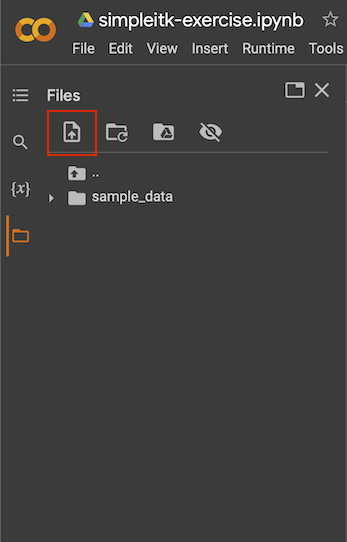

Use the Files tab on the left to upload the exercise file .zip file to the instance. This .zip file should be provided to you by the instructors. Your instance should now have access to the exercise.zip file for the next section to run without errors.

The following section unzips the data and loads it in the filesystem for this instance.

In [8]:
zip_ref = zipfile.ZipFile("/content/exercise.zip", 'r')
zip_ref.extractall("/content/")
zip_ref.close()

Run the section below to run tests to check if you have implemented the functions correctly. The outputs should indicate if you passed or not.

In [11]:
# --- DO NOT CHANGE

callback = helper.TestCallback()
callback.start('Pipeline')

callback.start_test('collect_image_paths')
crawler = collect_image_paths('/content/exercise')
if isinstance(crawler, futil.FileSystemDataCrawler):
    image_paths_ = crawler.data
    subject_x_paths = image_paths_.get('subjectX')  # only consider subjectX
    identifier = subject_x_paths.pop('subjectX', '')
    collect_ok = all((identifier.endswith('subjectX'),
                        structure.BrainImageTypes.GroundTruth in subject_x_paths,
                        structure.BrainImageTypes.T1w in subject_x_paths))
else:
    collect_ok = False
    subject_x_paths = None  # for load_images
callback.end_test(collect_ok)

callback.start_test('load_images')
if isinstance(subject_x_paths, dict):
    subject_x_images = load_images(subject_x_paths)
    image_type_ok = all(isinstance(img, sitk.Image) for img in subject_x_images.values())
    load_ok = isinstance(subject_x_images, dict) and image_type_ok
else:
    load_ok = False
    subject_x_images = None  # for preprocess_filter_rescale_t1
callback.end_test(load_ok)

callback.start_test('register_images')
atlas_img_ = sitk.ReadImage('/content/exercise/mni_icbm152_t1_tal_nlin_sym_09a.nii.gz')
if isinstance(subject_x_paths, dict):
    registered_img, registered_gt_ = register_images(subject_x_images, atlas_img_)
    if isinstance(registered_img, sitk.Image) and isinstance(registered_gt_, sitk.Image):
        stats = sitk.LabelStatisticsImageFilter()
        stats.Execute(registered_img, registered_gt_)
        labels = tuple(sorted(stats.GetLabels()))
        register_ok = registered_img.GetSize() == registered_gt_.GetSize() == (197, 233, 189) and labels == tuple(
            range(6))
    else:
        register_ok = False
else:
    register_ok = False
callback.end_test(register_ok)

callback.start_test('preprocess_filter_rescale_t1')
if isinstance(subject_x_images, dict):
    pre_rescale = preprocess_filter_rescale_t1(subject_x_images, -3, 101)
    if isinstance(pre_rescale, sitk.Image):
        min_max = sitk.MinimumMaximumImageFilter()
        min_max.Execute(pre_rescale)
        pre_ok = min_max.GetMinimum() == -3 and min_max.GetMaximum() == 101
    else:
        pre_ok = False
else:
    pre_ok = False
callback.end_test(pre_ok)

callback.start_test('extract_feature_median_t1')
if isinstance(subject_x_images, dict):
    median_img_ = extract_feature_median_t1(subject_x_images)
    if isinstance(median_img_, sitk.Image):
        median_ref = sitk.ReadImage('/content/exercise/subjectX/T1med.nii.gz')
        min_max = sitk.MinimumMaximumImageFilter()
        min_max.Execute(median_img_ - median_ref)
        median_ok = min_max.GetMinimum() == 0 and min_max.GetMaximum() == 0
    else:
        median_ok = False
else:
    median_ok = False
callback.end_test(median_ok)

callback.end()


------- Pipeline Exercise ----------

collect_image_paths:	failed
load_images:	failed
register_images:	failed
preprocess_filter_rescale_t1:	failed
extract_feature_median_t1:	failed

------ 5 tests failed. Keep on trying! --------


Once all the tests pass (or you've tried your best until the deadline), please download this notebook using the File --> Download --> Download .ipynb option. Then, go back to your GitHub repository for the assignment, and upload this file and commit the change to submit your assignment!